In [414]:
import os 
import numpy as np
import pandas as pd
import os
import sqlite3
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import ollama
import sqlite3
import pandas as pd 
import numpy as np
import contractions                                                                                                      
import re
from mlxtend.frequent_patterns import apriori, association_rules
import json
from pandas import json_normalize
from sklearn.metrics import classification_report
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Ground Dataset

In [277]:
human_df= pd.read_csv("precise_answer.csv")

In [349]:
cols = ["age", "gender", "occupation", "country"]
human_df_binary = human_df[cols].notna().astype(int)
human_df_binary["username"] = human_df["username"]
#uman_df[cols] = human_df[cols].apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0).astype(int)

Ground truth shape:  (100, 5)
age           55
gender        65
occupation    50
country       55
dtype: int64


Text(0.5, 1.0, 'Presence of Identity Attributes on Ground Truth Dataset')

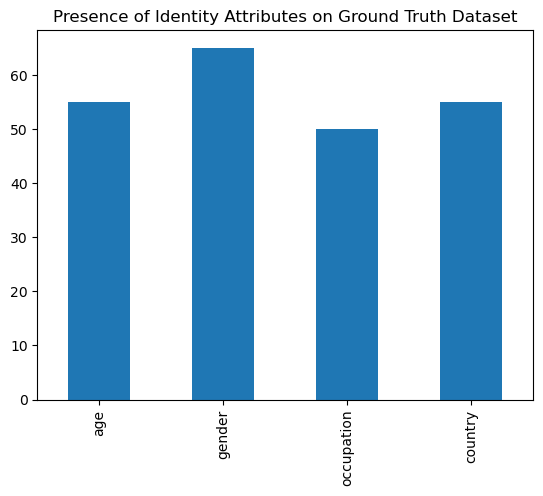

In [482]:
print("Ground truth shape: ", human_df_binary.shape)
print(human_df_binary[cols].sum())

human_df_binary[cols].sum().plot(kind="bar")
plt.title("Presence of Identity Attributes on Ground Truth Dataset")

In [260]:
with open('analysis/static_files/info_dump.json') as f:
    json_dump = json.load(f)   

In [466]:
print(f"There are {len(json_dump["usernames"])} usernames")

There are 199 usernames
There are 199 key, value pairs


# Binary: Found - Not Found: Compare Results

In [ ]:
usernames_json = list(json_dump["usernames"].keys())
usernames_human = human_df["username"].tolist()

In [467]:

def build_rag_binary(json_dump):
    rag_df_binary = pd.DataFrame(columns =["username","age", "gender", "occupation", "country"])
    for user, dict_ in json_dump["usernames"].items():
        new_row = {
            "username": user,
            "age": 0,
            "gender": 0,
            "occupation": 0,
            "country": 0
        }
        if 'age' in dict_:
            if str(dict_["age"]).strip().lower() !="n/a":
                new_row["age"] = 1
        if 'country' in dict_:
            if dict_["country"].strip().lower() !="n/a":
                new_row["country"] = 1
        if 'gender' in dict_:
            if dict_['gender'].strip().lower() !="n/a":
                new_row["gender"] = 1
        if 'occupation' in dict_:
            if dict_["occupation"].strip().lower() !="n/a":
                new_row["occupation"] = 1   
        rag_df_binary.loc[len(rag_df_binary)] = new_row
    return rag_df_binary
rag_binary_ = build_rag_binary(json_dump)

age            29
gender        131
occupation     69
country        89
dtype: int64


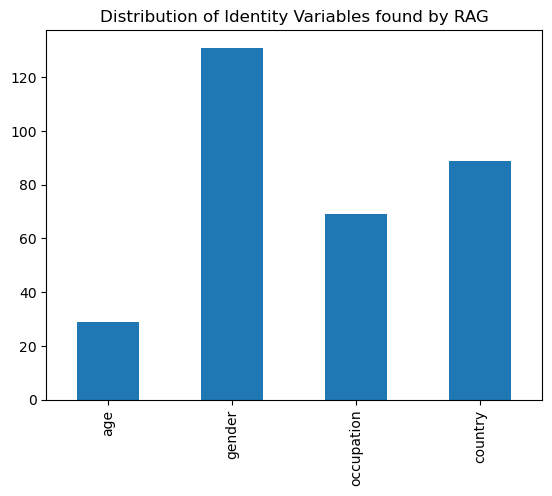

In [464]:
rag_binary_[["age", "gender", "occupation", "country"]].sum().plot(kind="bar")
plt.title("Distribution of Identity Variables found by RAG")
print(rag_binary_[["age", "gender", "occupation", "country"]].sum())

In [283]:
columns = ["age", "gender","occupation", "country"]
def get_classification_scores_individually_binary(human_df,rag_df, columns = ["age", "gender","occupation", "country"]):
    results_dict = {"gender":[], 
                   "occupation":[],            
                    "country":[],
                    "all":[],
                    "age":[],
                    "shared_all":[]                    
                    }
   
    rag_answer =[]
    rag_df = rag_df[rag_df["username"].isin(human_df["username"].tolist())]
    human_df = human_df[human_df["username"].isin(rag_df["username"].tolist())]
    for username in usernames_human:
        if username in rag_df["username"].tolist():
            human_row = human_df[human_df["username"] == username][columns].iloc[0]
            rag_row = rag_df[rag_df["username"] == username][columns].iloc[0]
            shared_all_rag = 1 if all(x == 1 for x in rag_row) else 0
            shared_all_human = 1 if all(x == 1 for x in human_row) else 0
                    
            match_flags = (human_row == rag_row).astype(int).tolist()
            age_human, gender_human, occupation_human, country_human = human_row
            age_rag, gender_rag, occupation_rag, country_rag = rag_row
            shared_all_human
            results_dict["gender"].append((gender_human,gender_rag))
            results_dict["occupation"].append((occupation_human,occupation_rag))
            results_dict["country"].append((country_human,country_rag))
            results_dict["age"].append((age_human, age_rag))
            results_dict["shared_all"].append((shared_all_human, shared_all_rag))
            human_rag = list(zip(human_row, rag_row))
            results_dict["all"].extend(human_rag)
 
    return results_dict, rag_df, human_df
results_dict, rag_df_binary, human_df_binary = get_classification_scores_individually_binary(human_df_binary, rag_df_binary)    

                         gender                        
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        34
           1       0.87      0.87      0.87        60

    accuracy                           0.83        94
   macro avg       0.82      0.82      0.82        94
weighted avg       0.83      0.83      0.83        94

                       occupation                      
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        48
           1       0.94      0.63      0.75        46

    accuracy                           0.80        94
   macro avg       0.83      0.79      0.79        94
weighted avg       0.83      0.80      0.79        94

                        country                        
-------------------------------------------------------
          

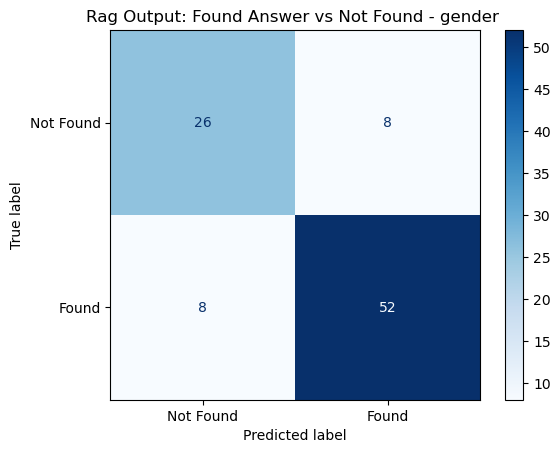

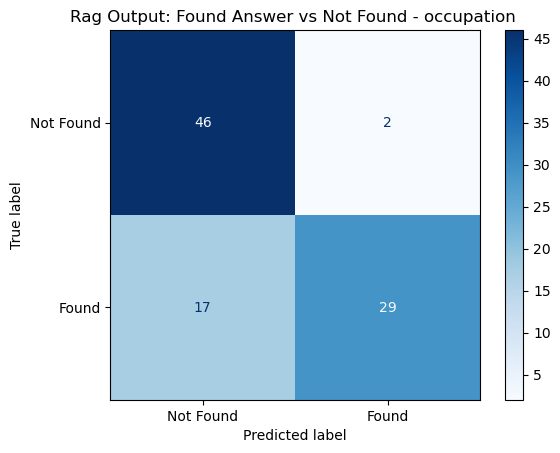

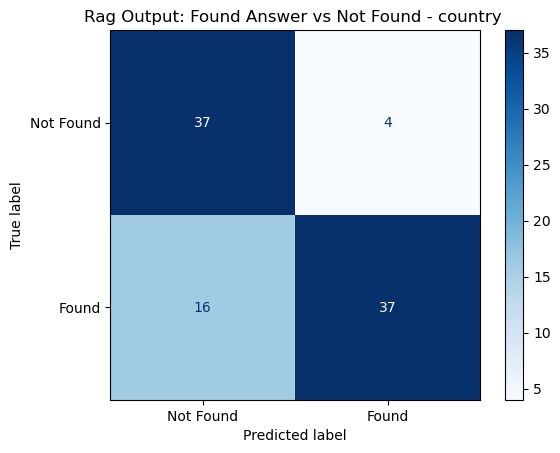

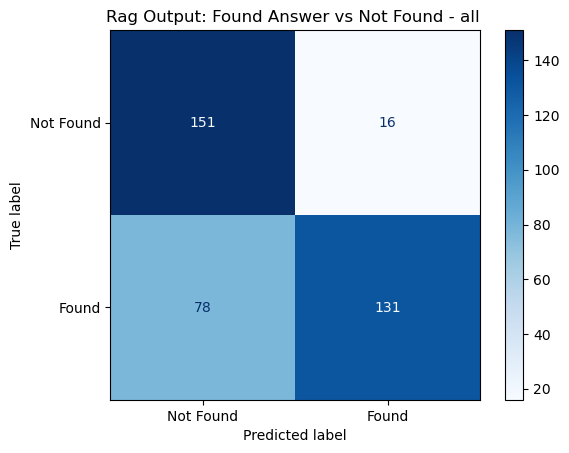

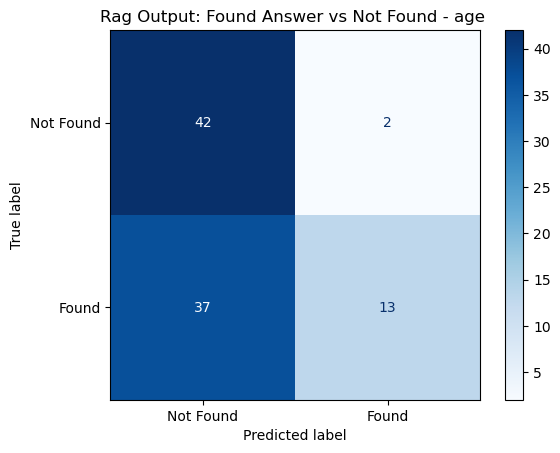

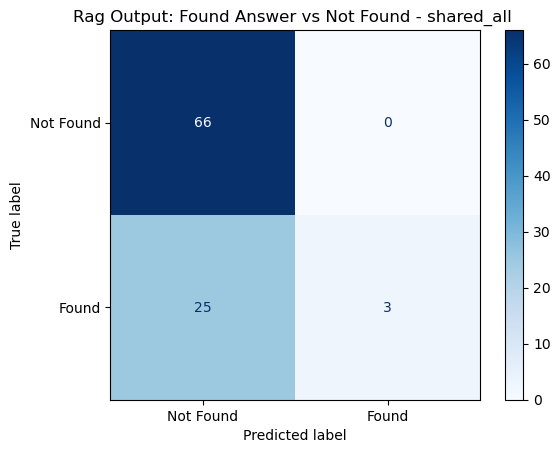

In [346]:
def plot_mosaics(results_dict):
    for key,item in results_dict.items():
        human = [h for h, r in item]
        rag = [r for h, r in item]
        print(f"{key}".center(55))
        print("-"*55)
        print(classification_report(human, rag))
        cm = confusion_matrix(human, rag)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Found", "Found"])
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Rag Output: Found Answer vs Not Found - {key} ")
        
plot_mosaics(results_dict)      

In [170]:
def plot_bar_plots(df, text_title=None,ax=None):
 
    if not text_title:
        text_title = "Comparison of Presence of Information"
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    cols = df.select_dtypes(include=np.number).columns.tolist()
    counts = df[cols].sum()
    counts.plot(kind="bar", ax=ax)
    ax.set_title(text_title)
    return ax
 

<Axes: title={'center': 'Comparison of presence of Information - Ground Truth'}>

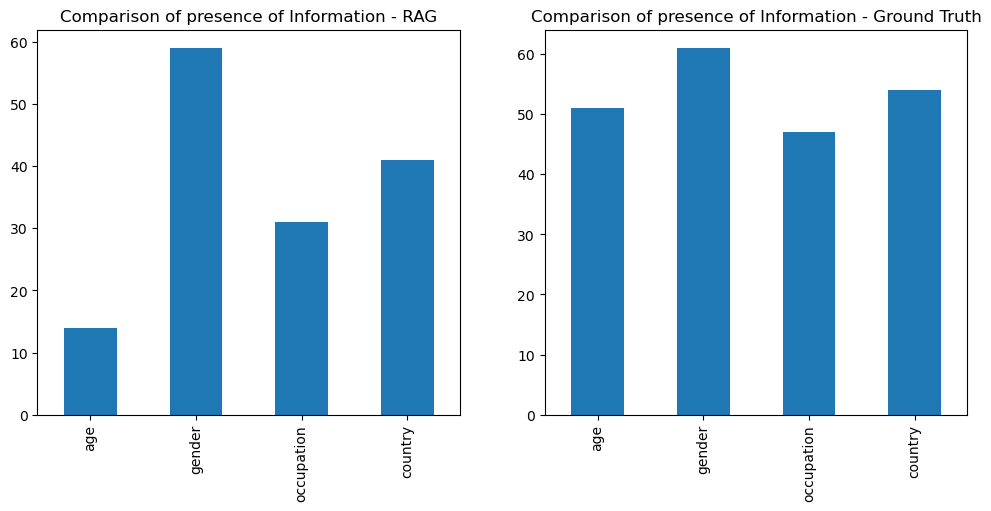

In [289]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_bar_plots(rag_df_binary,text_title="Comparison of presence of Information - RAG", ax=ax[0] )
plot_bar_plots(human_df_binary,text_title="Comparison of presence of Information - Ground Truth", ax=ax[1] )

# Accuracy by correct selection

In [324]:
score_df.sum()

age           53
gender        60
occupation    67
country       72
dtype: int64

In [338]:
def check_correctness(human_df, rag_json, cols = ["age", "gender","occupation", "country"]):
    score_df = pd.DataFrame(columns=cols)
    usernames = human_df["username"].tolist()
    usernames_ = []
    for user in usernames:
        temp = [0,0,0,0]
        if user not in rag_json.get("usernames", {}):
            continue
        h_age,h_gender,h_occup, h_country = human_df[human_df["username"]== user][cols].iloc[0]
        rag_item = rag_json["usernames"][user]
        
        if pd.isna(h_age):
            temp[0] = 1 if str(rag_item.get("age", "")).lower().strip() == 'n/a' or "age" not in rag_item else 0
        else:
            if 'age' in rag_item.keys():
               age_str=str(h_age).split()
               for s_age in age_str:
                    if s_age.strip() in str(rag_item["age"]).strip():
                        temp[0] = 1
                        break
                            
        if pd.isna(h_gender):
            temp[1] = 1 if rag_item.get("gender", "").lower().strip() == 'n/a' or "gender" not in rag_item else 0
        else:
            if 'gender' in rag_item.keys():
                h_gender = "female" if h_gender == "F" else "male"
                gender_r = rag_item["gender"].lower().strip()
                if gender_r == h_gender:
                    temp[1] = 1

        
        if pd.isna(h_occup):
            temp[2] = 1 if rag_item.get("occupation", "").lower().strip() == 'n/a' or "occupation" not in rag_item else 0
        else:
            if 'occupation' in rag_item.keys():
                occupation_str = h_occup.lower().split()
                for occ in occupation_str:
                    if occ.strip() in rag_item["occupation"].lower().split():
                        temp[2] = 1
                        break
        if pd.isna(h_country):
            temp[3] = 1 if rag_item.get("country", "").lower().strip() == 'n/a' or "country" not in rag_item else 0
        else:    
            if 'country' in rag_item.keys():  
                country_r = rag_item["country"].lower()     
                if country_r.strip() == h_country.lower().strip():
                        temp[3] = 1
        usernames_.append(user)
        score_df.loc[len(score_df)] = temp
    return score_df, usernames
                
        

In [339]:
score_df, usernames = check_correctness(human_df, json_dump)

age           0.574468
gender        0.638298
occupation    0.712766
country       0.765957
dtype: float64


Text(0.5, 1.0, 'Accuracy of RAG Outputs by Identity Attribute')

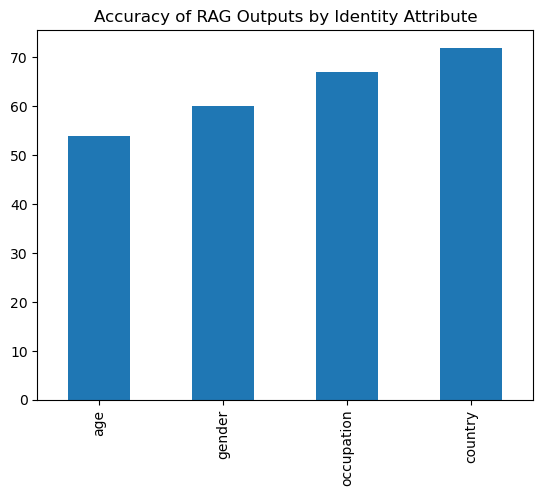

In [426]:
print(score_df.sum()/94)
score_df.sum().plot(kind='bar')
plt.title("Accuracy of RAG Outputs by Identity Attribute")

In [352]:
all_ones_count = (score_df == 1).all(axis=1).sum()
print("Rows where all answers were correct", all_ones_count)

Rows with all 1s: 23


In [353]:
all_ones_count = (score_df == 0).all(axis=1).sum()
print("Rows where all answers where wrong", all_ones_count)

Rows with all 0s: 1


# Perform on Non-Annotated Dataset

In [485]:
all_json_results = build_rag_binary(json_dump)
cols = ["age", "gender","occupation", "country"]

In [486]:
all_json_results.shape

(199, 5)

In [487]:
all_ones_count = (all_json_results[cols] == 1).all(axis=1).sum()
print("Rows with all variables found: ", all_ones_count)
at_least_one = (all_json_results[cols] == 1).sum(axis=1).ge(1).sum()
print("Rows with at least 1 variables:", at_least_one)

Rows with all variables found:  9
Rows with at least 1 variables: 139


In [489]:
all_ones_count = (all_json_results[cols] == 0).all(axis=1).sum()
all_zero_rows = (all_json_results[cols] == 0).all(axis=1)
indexes = all_json_results[all_zero_rows].index.tolist()
usernames_zero_counts = all_json_results.loc[indexes]["username"].tolist()
usernames_not_zero_counts = all_json_results.loc[
    ~all_json_results["username"].isin(usernames_zero_counts),
    "username"
].tolist()
print("Rows with no variables found", all_ones_count)
print("Rows with at least 1 variable found", len(usernames_not_zero_counts))

Rows with no variables found 60
Rows with at least 1 variable found 139


In [490]:
all_ones_count = (all_json_results[cols] == 0).all(axis=1).sum()
print("Rows with all 0s:", all_ones_count)

Rows with all 0s: 60


In [475]:
three_ones_count = (all_json_results[cols] == 1).sum(axis=1).eq(3).sum()
three_ones_rows = (all_json_results[cols] == 1).sum(axis=1).eq(3)
indexes_three_atts = all_json_results[three_ones_rows].index.tolist()
usernames_three_counts = all_json_results.loc[indexes_three_atts]["username"].tolist()
print("Rows with exactly 3 variables:", three_ones_count)

Rows with exactly 3 variables: 53


Text(0.5, 1.0, 'Presence of Identity Attributes')

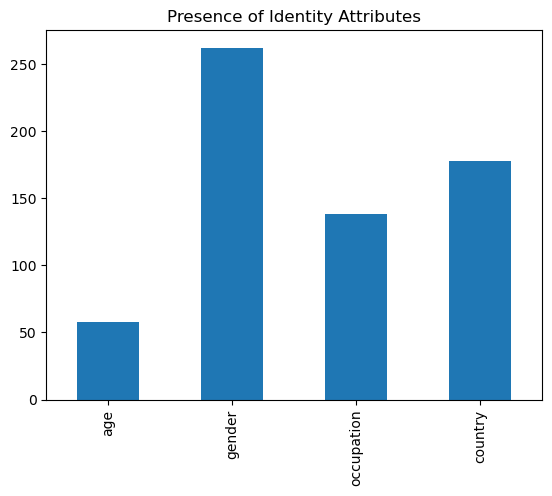

In [421]:
all_json_results[cols].sum().plot(kind='bar')
plt.title("Presence of Identity Attributes")

# Association rules

In [476]:
binary_df = all_json_results[cols].astype(bool)
frequent_itemsets = apriori(binary_df, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, num_itemsets=len(binary_df), metric="confidence", min_threshold=0.5)
display(rules[['antecedents', 'consequents', 'support', 'lift',]].sort_values(by="lift", ascending=False))

,antecedents,consequents,support,lift
8,"(occupation, gender)",(country),0.236181,1.722785
9,(country),"(occupation, gender)",0.236181,1.722785
5,(occupation),(country),0.236181,1.523042
10,(occupation),"(country, gender)",0.236181,1.523042
4,(country),(occupation),0.236181,1.523042
7,"(country, gender)",(occupation),0.236181,1.523042
0,(age),(gender),0.145729,1.519084
2,(country),(gender),0.447236,1.519084
3,(gender),(country),0.447236,1.519084
6,"(country, occupation)",(gender),0.236181,1.519084


# Observing Results Against EDA

In [407]:
conn = sqlite3.connect('scraper/i_513_project.db')
cursor = conn.cursor()
query="SELECT * FROM posts"
df_posts = pd.read_sql(query,conn)

In [422]:
def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopWords = set(stopwords.words('english'))
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        self.lemmatizer = WordNetLemmatizer()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X[self.col] = X[self.col].apply(lambda x: contractions.fix(x))
        
        X[self.col] = X[self.col].apply(lambda x: re.sub(r'[^\w\s]', ' ', x.lower()))
 
        X[self.col] = X[self.col].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
       
        X[self.col] = X[self.col].apply(lambda x: ' '.join([t for t in x.split() if t not in stopWords]))
        
        X[self.col + "_#words"] = X[self.col].apply(lambda x: len(x.split()))
        print(self.col + "_#words")
        X[self.col + "_stemmed"] = X[self.col].apply(lambda x: ' '.join(stemmer.stem(word) for word in x.split()) )

        #Lemmatization
        tokens = X[self.col].apply(word_tokenize)
        tags = tokens.apply(pos_tag)
        X[self.col + "_lemmatized"] = tags.apply(lambda tagged: ' '.join(self.lemmatizer.lemmatize( w, get_wordnet_pos(pos) ) for w, pos in tagged))
  
        return X

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zashabenites/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [423]:
text_transformer = TextPreprocessor("post_text")
text_transformer.fit(df_posts)
df_posts_transformed =text_transformer.transform(df_posts)

post_text_#words


In [411]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23482 entries, 0 to 23481
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              23482 non-null  int64 
 1   username        23482 non-null  object
 2   post_id         23482 non-null  object
 3   title           23482 non-null  object
 4   post_text       23482 non-null  object
 5   score           23482 non-null  int64 
 6   subreddit_name  23482 non-null  object
 7   n_comments      23482 non-null  int64 
 8   timestamp       23482 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


In [479]:
avg_n_words_no_info = df_posts_transformed[df_posts_transformed["username"].isin(usernames_zero_counts)]["post_text_#words"].mean()
avg_n_words_info = df_posts_transformed[df_posts_transformed["username"].isin(usernames_not_zero_counts)]["post_text_#words"].mean()
avg_n_words_3 = df_posts_transformed[df_posts_transformed["username"].isin(usernames_three_counts)]["post_text_#words"].mean()
print("The average number of words in a post with no identity attributes found by the RAG pipeline is: ",avg_n_words_no_info )
print("The average number of words in a post with identity attributes found by the RAG pipeline is: ",avg_n_words_info )
print("The average number of words in a post with 3 identity attributes found by the RAG pipeline is: ",avg_n_words_3 )


The average number of words in a post with no identity attributes found by the RAG pipeline is:  40.36065573770492
The average number of words in a post with identity attributes found by the RAG pipeline is:  66.50452979456425
The average number of words in a post with 3 identity attributes found by the RAG pipeline is:  61.082848837209305


In [480]:
avg_n_posts_no_info =df_posts[df_posts["username"].isin(usernames_zero_counts)]["username"].value_counts().mean()
avg_n_posts_info =df_posts[df_posts["username"].isin(usernames_not_zero_counts)]["username"].value_counts().mean()
avg_n_posts_3_info =df_posts[df_posts["username"].isin(usernames_three_counts)]["username"].value_counts().mean()
print("The average number of posts with users with no identity attributes found by the RAG pipeline is: ",avg_n_posts_no_info )
print("The average number of posts with users with identity attributes found by the RAG pipeline is: ",avg_n_posts_info )
print("The average number of posts with users with 3 identity attributes found by the RAG pipeline is: ",avg_n_posts_3_info )

The average number of posts with users with no identity attributes found by the RAG pipeline is:  4.066666666666666
The average number of posts with users with identity attributes found by the RAG pipeline is:  56.381294964028775
The average number of posts with users with 3 identity attributes found by the RAG pipeline is:  64.90566037735849
